# Nearest Neighbors

When exploring a large set of documents -- such as Wikipedia, news articles, StackOverflow, etc. -- it can be useful to get a list of related material. To find relevant documents you typically
* Decide on a notion of similarity
* Find the documents that are most similar 

In the assignment you will
* Gain intuition for different notions of similarity and practice finding similar documents. 
* Explore the tradeoffs with representing documents using raw word counts and TF-IDF
* Explore the behavior of different distance metrics by looking at the Wikipedia pages most similar to President Obama’s page.

## Import necessary packages

As usual we need to first import the Python packages that we will need.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

## Load Wikipedia dataset

We will be using the same dataset of Wikipedia pages that we used in the Machine Learning Foundations course (Course 1). Each element of the dataset consists of a link to the wikipedia article, the name of the person, and the text of the article (in lowercase).  

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/FUNIX Progress/MLP304x_01-A_EN/data/people_wiki.csv', header=0)

In [ ]:
data.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


## Extract word count vectors

As we have seen in Course 1, we can extract word count vectors using a Scikit-learn's `CountVectorizer` class.  We keep this as a `wiki_word_count`, which is a `scipy.sparse` matrix specialized in sparse data (big dimensions with comparatively few numbers)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
#from nltk import word_tokenize
vectorizer = CountVectorizer() #max_features=200000, tokenizer=word_tokenize
wiki_word_count = vectorizer.fit_transform(data["text"])

In [ ]:
np.shape(wiki_word_count)

(59071, 548429)

## Find nearest neighbors

Let's start by finding the nearest neighbors of the Barack Obama page using the word count vectors to represent the articles and Euclidean distance to measure distance.  For this, again will we will use a nifty implementation of nearest neighbor search.

In [ ]:
from sklearn.neighbors import NearestNeighbors

model = NearestNeighbors(metric='euclidean')
model.fit(wiki_word_count)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

Let's look at the top 10 nearest neighbors by performing the following query:

In [ ]:
query_index = pd.Index(data['name']).get_loc('Barack Obama')
query = wiki_word_count[query_index]
indices = model.kneighbors(query, n_neighbors=11, return_distance=False)
print("Nearest neighbors found:\n", data['name'].iloc[indices[0][1:]])

Nearest neighbors found:
 24478                     Joe Biden
28447                George W. Bush
14754                   Mitt Romney
35357              Lawrence Summers
31423                Walter Mondale
13229              Francisco Barrio
36364                    Don Bonker
22745    Wynn Normington Hugh-Jones
7660       Refael (Rafi) Benvenisti
9210                   Andy Anstett
Name: name, dtype: object


All of the 10 people are politicians, but about half of them have rather tenuous connections with Obama, other than the fact that they are politicians.

* Francisco Barrio is a Mexican politician, and a former governor of Chihuahua.
* Walter Mondale and Don Bonker are Democrats who made their career in late 1970s.
* Wynn Normington Hugh-Jones is a former British diplomat and Liberal Party official.
* Andy Anstett is a former politician in Manitoba, Canada.

Nearest neighbors with raw word counts got some things right, showing all politicians in the query result, but missed finer and important details.

For instance, let's find out why Francisco Barrio was considered a close neighbor of Obama.  To do this, let's look at the most frequently used words in each of Barack Obama and Francisco Barrio's pages:

In [ ]:
idx_lookup_vocab = {i:w for w, i in vectorizer.vocabulary_.items()}

def top_words(name, most_freq_count=10):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
    query_index = pd.Index(data['name']).get_loc(name)
    word_count_raw = wiki_word_count[query_index].toarray().ravel()
#    print(np.shape(wiki_word_count), np.shape(word_count_raw))
    # reverse the word count to argsort from highest to lowest (sort default to ascending)
    best_words_ids = np.argsort(word_count_raw, axis=-1)[::-1][:most_freq_count]
#    print(query_index, np.shape(word_count_raw), best_words_ids)
    best_words = [idx_lookup_vocab[idx] for idx in best_words_ids]
#    word_count_table = row[['word_count']].stack('word_count', new_column_name=['word','count'])
    return best_words

In [ ]:
obama_words = top_words('Barack Obama')
obama_words

['the', 'in', 'and', 'of', 'to', 'his', 'obama', 'act', 'he', 'us']

In [ ]:
barrio_words = top_words('Francisco Barrio')
barrio_words

['the', 'of', 'and', 'in', 'he', 'to', 'chihuahua', 'governor', 'as', 'his']

Let's extract the list of most frequent words that appear in both Obama's and Barrio's documents. We've so far sorted all words from Obama and Barrio's articles by their word frequencies. We will now use a dataframe operation known as **join**. The **join** operation is very useful when it comes to playing around with data: it lets you combine the content of two tables using a shared column (in this case, the word column). See [the documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) for more details.

For instance, running
```
obama_words_frame.join(barrio_words_frame)
```
will extract the rows from both tables that correspond to the common words. Note that it will join on the index, so both dataframe either must be made from a pandas `Series` or have already set the column to join as index.

In [ ]:
from collections import Counter

def create_series_from_text(text):
    word_counter = Counter(text.strip().split())
    words, numwords = zip(*word_counter.items())
    return pd.Series(data=numwords, index=words)
    
def create_series_from_name(name):
    return create_series_from_text(data[data["name"] == name]["text"].iloc[0])

In [ ]:
obama_words = create_series_from_name("Barack Obama")
barrio_words = create_series_from_name("Francisco Barrio")
combined_words = obama_words.to_frame(name="Obama").join(barrio_words.to_frame(name="Barrio"), how="outer")
combined_words

,Obama,Barrio
13th,1.0,NaN
1950,NaN,1.0
1961,1.0,NaN
1983,NaN,1.0
1986,NaN,1.0
...,...,...
women,NaN,1.0
won,1.0,1.0
wore,NaN,1.0
worked,1.0,1.0


As you can see, when the dataframe is joined as *outer*, the missing values are **NaN**. To resolve this, we use operation `.fillna` to fill it with the correct values

In [ ]:
combined_words = combined_words.fillna(0)
combined_words

,Obama,Barrio
13th,1.0,0.0
1950,0.0,1.0
1961,1.0,0.0
1983,0.0,1.0
1986,0.0,1.0
...,...,...
women,0.0,1.0
won,1.0,1.0
wore,0.0,1.0
worked,1.0,1.0


**Note**. The **join** operation does not enforce any particular ordering on the shared column. So to obtain, say, the five common words that appear most often in Obama's article, sort the combined table by the Obama column. Don't forget `ascending=False` to display largest counts first.

In [ ]:
combined_words = combined_words['Obama'].sort_values(ascending=False)
combined_words.head(10)

the      40.0
in       30.0
and      21.0
of       18.0
to       14.0
his      11.0
obama     9.0
act       8.0
a         7.0
he        7.0
Name: Obama, dtype: float64

**Quiz Question**. Among the words that appear in both Barack Obama and Francisco Barrio, take the 5 that appear most frequently in Obama. How many of the articles in the Wikipedia dataset contain all of those 5 words?

Hint:
* Refer to the previous paragraph for finding the words that appear in both articles. Sort the common words by their frequencies in Obama's article and take the largest five.
* We currently keep the text as a large string object. For each of these string, you'd have to check if the set of the 5 common words we have is a subset of the keys of the word count vector. Complete the function `has_top_words` to accomplish the task.
  - Convert the list of top 5 words into set using the syntax
```
set(common_words)
```
    where `common_words` is a Python list. See [this link](https://docs.python.org/2/library/stdtypes.html#set) if you're curious about Python sets.
  - We can easily convert a list to a set, in which case all duplicate values are discarded one. Since our data is already tokenized, the text can be splitted with the `.split` command
  - Convert the list of keys into a set as well.
  - Check if all the common words belongs to the keys as needed.
* Now apply the `has_top_words` function on the **text** column to retrieve the True/False assertion.
* Compute the sum of the result column to obtain the number of articles containing all the 5 top words.

**Minor insight: The usual way in Python to check if a string `s1` is a substring of another string `s2` is `s1 in s2`. Could we use it here? Why (not)?**

In [ ]:
common_words = set(['the', 'in', 'and', 'of', 'to']) # YOUR CODE HERE

def has_top_words(text):
    # extract the keys of word_count_vector and convert it to a set
    unique_words = set(text.split())   # YOUR CODE HERE
    # return True if common_words is a subset of unique_words
    # return False otherwise
    return common_words.issubset(unique_words)  # YOUR CODE HERE

data['has_top_words'] = data['text'].apply(has_top_words)

# use has_top_words column to answer the quiz question
len(data[data['has_top_words'] == True])

56066

**Checkpoint**. Check your `has_top_words` function on two random articles:

In [ ]:
print('Output from your function:', has_top_words(data.iloc[32]['text']))
print('Correct output: True')
print('Also check the length of unique_words. It should be 167')
print(len(set(data.iloc[32]['text'].strip().split())))

Output from your function: True
Correct output: True
Also check the length of unique_words. It should be 167
167


In [ ]:
print('Output from your function:', has_top_words(data.iloc[33]['text']))
print('Correct output: False')
print('Also check the length of unique_words. It should be 188')
print(len(set(data.iloc[33]['text'].strip().split())))

Output from your function: False
Correct output: False
Also check the length of unique_words. It should be 188
188


**Quiz Question**. Measure the pairwise distance between the Wikipedia pages of Barack Obama, George W. Bush, and Joe Biden. Which of the three pairs has the smallest distance?

Hints: 
* To compute the Euclidean distance between two vector, use `sklearn.metrics.pairwise.euclidean_distances`. Refer to [this link](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.euclidean_distances.html) for usage.
* When finding a row using specific column value, take the index 0 to access the first match. (Round your answer to three decimal places.)

In [ ]:
data.index[data['name'] == 'Barack Obama'].tolist()

[35817]

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
# retrieve the vectors and calculate

obama_idx = data.index[data['name'] == 'Barack Obama'].tolist()
bush_idx = data.index[data['name'] == 'George W. Bush'].tolist()
joe_idx = data.index[data['name'] == 'Joe Biden'].tolist()

print(euclidean_distances(wiki_word_count[obama_idx], wiki_word_count[bush_idx])[0][0])
print(euclidean_distances(wiki_word_count[obama_idx], wiki_word_count[joe_idx])[0][0])
print(euclidean_distances(wiki_word_count[bush_idx], wiki_word_count[joe_idx])[0][0])

34.307433596816885
33.015148038438355
32.69556544854363


**Quiz Question**. Collect all words that appear both in Barack Obama and George W. Bush pages.  Out of those words, find the 10 words that show up most often in Obama's page.

In [ ]:
obama_words = create_series_from_name("Barack Obama")
barrio_words = create_series_from_name("George W. Bush")
combined_words = obama_words.to_frame(name="Obama").join(barrio_words.to_frame(name="Bush"), how="outer")
combined_words = combined_words.fillna(0)
combined_words = combined_words['Obama'].sort_values(ascending=False)
combined_words.head(10)

the      40.0
in       30.0
and      21.0
of       18.0
to       14.0
his      11.0
obama     9.0
act       8.0
he        7.0
a         7.0
Name: Obama, dtype: float64

**Note.** Even though common words are swamping out important subtle differences, commonalities in rarer political words still matter on the margin. This is why politicians are being listed in the query result instead of musicians, for example. In the next subsection, we will introduce a different metric that will place greater emphasis on those rarer words.

## TF-IDF to the rescue

Much of the perceived commonalities between Obama and Barrio were due to occurrences of extremely frequent words, such as "the", "and", and "his". So nearest neighbors is recommending plausible results sometimes for the wrong reasons. 

To retrieve articles that are more relevant, we should focus more on rare words that don't happen in every article. **TF-IDF** (term frequency–inverse document frequency) is a feature representation that penalizes words that are too common.  Let's use sklearn's implementation of TF-IDF named `TfidfVectorizer`, which is a combination of the previous `CountVectorizer` and a `TfidfTransformer` that will calculate the concerning TF-IDFs. We repeat the search for the 10 nearest neighbors of Barack Obama:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True) # max_features=200000
tfidf_word_count = tfidf_vectorizer.fit_transform(data["text"])

In [ ]:
tfidf_model = NearestNeighbors(metric='euclidean')
tfidf_model.fit(tfidf_word_count)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
def tfidf_query_knn(name, return_distance=False, n_neighbors=10):
    query_index = pd.Index(data['name']).get_loc(name)
    query = tfidf_word_count[query_index]
    distances, indices = tfidf_model.kneighbors(query, n_neighbors=n_neighbors+1)
    return distances, data.iloc[indices[0][1:]]
print("Nearest neighbors found:\n", tfidf_query_knn('Barack Obama')[-1]["name"])

Nearest neighbors found:
 24478                 Joe Biden
57108    Hillary Rodham Clinton
4408              Joe Lieberman
48693               Artur Davis
46811             Jeff Sessions
28447            George W. Bush
36452              Bill Clinton
47303                John Kerry
38376            Samantha Power
9073               Thomas Perez
Name: name, dtype: object


Let's determine whether this list makes sense.
* They are all American politicians who are contemporaries of Barack Obama.
* Samantha Power and ... worked for Obama.

Clearly, the results are more plausible with the use of TF-IDF. Let's take a look at the word vector for Obama and Stern's pages. Notice that TF-IDF representation assigns a weight to each word. This weight captures relative importance of that word in the document. Let us sort the words in Obama's article by their TF-IDF weights; we do the same for Stern's article as well.

In [ ]:
tfidf_lookup_vocab = {i:w for w, i in tfidf_vectorizer.vocabulary_.items()}

def retrieve_tfidf_vector(name):
    return tfidf_vectorizer.transform(data[data['name'] == name]["text"]).toarray().ravel()
    
def top_words_tf_idf(name, most_freq_count=10):
    tfidf_vector = retrieve_tfidf_vector(name)
    best_words_ids = np.argsort(tfidf_vector, axis=-1)[::-1][:most_freq_count]
    #print(np.shape(tfidf_vector), best_words_ids)
    best_words = [tfidf_lookup_vocab[idx] for idx in best_words_ids]
    return best_words

In [ ]:
obama_tf_idf = top_words_tf_idf('Barack Obama')
obama_tf_idf

['obama',
 'act',
 'iraq',
 'ordered',
 'laureateduring',
 '2012obama',
 'husen',
 'control',
 'involvement',
 'response']

In [ ]:
power_tf_idf = top_words_tf_idf('Samantha Power')
power_tf_idf

['obama',
 'multilateral',
 'genocide',
 'councilresponsible',
 'nationspower',
 'rightspositions',
 'monsterpower',
 'forbespower',
 'rights',
 'militarily']

Using the **join** operation we learned earlier, try your hands at computing the common words shared by Obama's and Power's articles. Sort the common words by their TF-IDF weights in Obama's document.

In [ ]:
obama_words = create_series_from_name("Barack Obama")
power_words = create_series_from_name("Samantha Power")
both = obama_words.to_frame(name="Obama").join(power_words.to_frame(name="Power"), how="inner")
obama_text = data[data['name'] == "Barack Obama"]["text"].iloc[0]
obama_tfidf_vector = tfidf_vectorizer.transform([obama_text])
obama_tfidf_values = {k: obama_tfidf_vector[0, i] for k, i in tfidf_vectorizer.vocabulary_.items()}
both["obama_tfidf"] = both.index.to_series().map(obama_tfidf_values)
both.sort_values(by='obama_tfidf', ascending=False).head(10)

,Obama,Power,obama_tfidf
obama,9,5,0.184492
response,3,1,0.109667
protection,2,2,0.089953
rodham,1,1,0.085974
campaign,3,2,0.083931
us,6,1,0.081316
presidential,2,1,0.078934
libya,1,1,0.072749
harvard,2,1,0.072605
foreign,2,1,0.070484


The first 10 words should contain the terms Obama, presidential, US, campaign.

**Quiz Question**. Among the words that appear in both Barack Obama and Samantha Power, take the 5 that have largest weights in Obama. How many of the articles in the Wikipedia dataset contain all of those 5 words?

In [ ]:
common_words = set(both.index[:5])

def has_top_words(text):
    # extract the keys of word_count_vector and convert it to a set
    unique_words = set(text.split())   # YOUR CODE HERE
    # return True if common_words is a subset of unique_words
    # return False otherwise
    return common_words.issubset(unique_words)  # YOUR CODE HERE

data['has_top_words'] = data['text'].apply(has_top_words)

# use has_top_words column to answer the quiz question
len(data[data['has_top_words'] == True])

210

Notice the huge difference in this calculation using TF-IDF scores instead  of raw word counts. We've eliminated noise arising from extremely common words.

## Choosing metrics

**Quiz Question**. Compute the Euclidean distance between TF-IDF features of Obama and Biden. (Round your answer to three decimal places.)

In [ ]:
# everything is already in places

In [ ]:
euclidean_distances([retrieve_tfidf_vector("Barack Obama")], [retrieve_tfidf_vector("Joe Biden")])

array([[1.18501445]])

The distance is larger than the distances we found for the 10 nearest neighbors, which we repeat here for readability:

In [ ]:
#model_tf_idf.query(wiki[wiki['name'] == 'Barack Obama'], label='name', k=10)
distances, rows = tfidf_query_knn('Barack Obama')
obama_tfidf_vector = retrieve_tfidf_vector("Barack Obama")
rows["distances"] = rows["name"].map(lambda name: euclidean_distances([obama_tfidf_vector], [retrieve_tfidf_vector(name)])[0][0])
rows

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,URI,name,text,has_top_words,distances
24478,<http://dbpedia.org/resource/Joe_Biden>,Joe Biden,joseph robinette joe biden jr dosf rbnt badn b...,True,1.185014
57108,<http://dbpedia.org/resource/Hillary_Rodham_Cl...,Hillary Rodham Clinton,hillary diane rodham clinton hlri dan rdm klnt...,True,1.222492
4408,<http://dbpedia.org/resource/Joe_Lieberman>,Joe Lieberman,joseph isadore joe lieberman born february 24 ...,False,1.236462
48693,<http://dbpedia.org/resource/Artur_Davis>,Artur Davis,artur genestre davis born october 9 1967 is an...,True,1.236839
46811,<http://dbpedia.org/resource/Jeff_Sessions>,Jeff Sessions,jefferson beauregard jeff sessions iii born de...,False,1.240793
28447,<http://dbpedia.org/resource/George_W._Bush>,George W. Bush,george walker bush born july 6 1946 is an amer...,False,1.250768
36452,<http://dbpedia.org/resource/Bill_Clinton>,Bill Clinton,william jefferson bill clinton born william je...,False,1.253769
47303,<http://dbpedia.org/resource/John_Kerry>,John Kerry,john forbes kerry born december 11 1943 is an ...,True,1.256045
38376,<http://dbpedia.org/resource/Samantha_Power>,Samantha Power,samantha power born september 21 1970 is an ir...,True,1.263746
9073,<http://dbpedia.org/resource/Thomas_Perez>,Thomas Perez,thomas edward perez born october 7 1961 is an ...,True,1.265955


But one may wonder, is Biden's article that different from Obama's, more so than, say, Power's? It turns out that, when we compute nearest neighbors using the Euclidean distances, we unwittingly favor short articles over long ones. Let us compute the length of each Wikipedia document, and examine the document lengths for the 100 nearest neighbors to Obama's page.

In [ ]:
def compute_length(text):
    return len(text.split(' '))

data['length'] = data['text'].apply(compute_length) 

In [ ]:
#nearest_neighbors_euclidean = model_tf_idf.query(wiki[wiki['name'] == 'Barack Obama'], label='name', k=100)
distances, rows = tfidf_query_knn('Barack Obama', n_neighbors=100)
rows.sort_values('length').head()
#nearest_neighbors_euclidean = nearest_neighbors_euclidean.join(wiki[['name', 'length']], on={'reference_label':'name'})

,URI,name,text,has_top_words,length
1293,<http://dbpedia.org/resource/Jay_Nixon>,Jay Nixon,jeremiah wilson jay nixon born february 13 195...,False,201
45068,<http://dbpedia.org/resource/Douglas_Schoen>,Douglas Schoen,douglas schoen is an american political analys...,False,202
7914,<http://dbpedia.org/resource/Phil_Schiliro>,Phil Schiliro,phil schiliro is an american political consult...,False,208
24837,<http://dbpedia.org/resource/Leon_Panetta>,Leon Panetta,leon edward panetta born june 28 1938 is an am...,True,209
1277,<http://dbpedia.org/resource/Kathryn_Biber>,Kathryn Biber,katie biber born 1978 is a well known american...,False,211


To see how these document lengths compare to the lengths of other documents in the corpus, let's make a histogram of the document lengths of Obama's 100 nearest neighbors and compare to a histogram of document lengths for all documents.

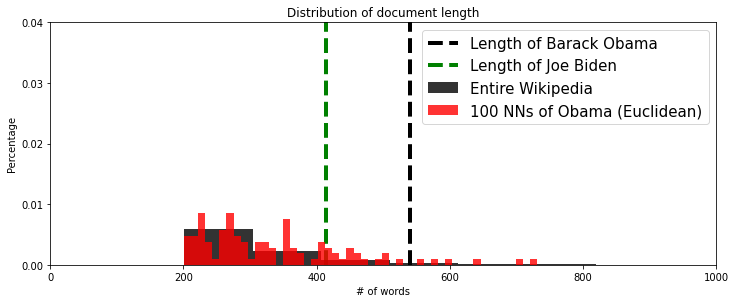

In [ ]:
plt.figure(figsize=(10.5,4.5))
plt.hist(data['length'], 50, color='k', edgecolor='None', histtype='stepfilled', density=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(rows['length'], 50, color='r', edgecolor='None', histtype='stepfilled', density=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.axvline(x=data[data['name'] == 'Barack Obama']['length'].iloc[0], color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=data[data['name'] == 'Joe Biden']['length'].iloc[0], color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])

plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

Relative to the rest of Wikipedia, nearest neighbors of Obama are overwhemingly short, most of them being shorter than 300 words. The bias towards short articles is not appropriate in this application as there is really no reason to  favor short articles over long articles (they are all Wikipedia articles, after all). Many of the Wikipedia articles are 300 words or more, and both Obama and Biden are over 300 words long.

**Note**: For the interest of computation time, the dataset given here contains _excerpts_ of the articles rather than full text. For instance, the actual Wikipedia article about Obama is around 25000 words. Do not be surprised by the low numbers shown in the histogram.

**Note:** Both word-count features and TF-IDF are proportional to word frequencies. While TF-IDF penalizes very common words, longer articles tend to have longer TF-IDF vectors simply because they have more words in them.

To remove this bias, we turn to **cosine distances**:
$$
d(\mathbf{x},\mathbf{y}) = 1 - \frac{\mathbf{x}^T\mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|}
$$
Cosine distances let us compare word distributions of two articles of varying lengths.

Let us train a new nearest neighbor model, this time with cosine distances.  We then repeat the search for Obama's 100 nearest neighbors.

In [ ]:
#model2_tf_idf = turicreate.nearest_neighbors.create(wiki, label='name', features=['tf_idf'],
#                                                    method='brute_force', distance='cosine')
tfidf_model2 = NearestNeighbors(metric='cosine')
tfidf_model2.fit(tfidf_word_count)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
def tfidf_query_knn2(name, return_distance=False, n_neighbors=10):
    query_index = pd.Index(data['name']).get_loc(name)
    query = tfidf_word_count[query_index]
    distances, indices = tfidf_model2.kneighbors(query, n_neighbors=n_neighbors+1)
    return distances, data.iloc[indices[0][1:]]
#nearest_neighbors_cosine = model2_tf_idf.query(wiki[wiki['name'] == 'Barack Obama'], label='name', k=100)
distances, rows2 = tfidf_query_knn2("Barack Obama", n_neighbors=100)
#nearest_neighbors_cosine = nearest_neighbors_cosine.join(wiki[['name', 'length']], on={'reference_label':'name'})
rows2["distance"] = distances[0][1:]
#print(len(rows), len(distances[0][1:]))
rows2.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,URI,name,text,has_top_words,length,distance
24478,<http://dbpedia.org/resource/Joe_Biden>,Joe Biden,joseph robinette joe biden jr dosf rbnt badn b...,True,414,0.702130
57108,<http://dbpedia.org/resource/Hillary_Rodham_Cl...,Hillary Rodham Clinton,hillary diane rodham clinton hlri dan rdm klnt...,True,580,0.747243
4408,<http://dbpedia.org/resource/Joe_Lieberman>,Joe Lieberman,joseph isadore joe lieberman born february 24 ...,False,457,0.764419
48693,<http://dbpedia.org/resource/Artur_Davis>,Artur Davis,artur genestre davis born october 9 1967 is an...,True,371,0.764885
46811,<http://dbpedia.org/resource/Jeff_Sessions>,Jeff Sessions,jefferson beauregard jeff sessions iii born de...,False,230,0.769784


From a glance at the above table, things look better.  For example, we now see Joe Biden as Barack Obama's nearest neighbor!  We also see Hillary Clinton on the list.  This list looks even more plausible as nearest neighbors of Barack Obama.

Let's make a plot to better visualize the effect of having used cosine distance in place of Euclidean on our TF-IDF vectors.

<Figure size 756x324 with 0 Axes>

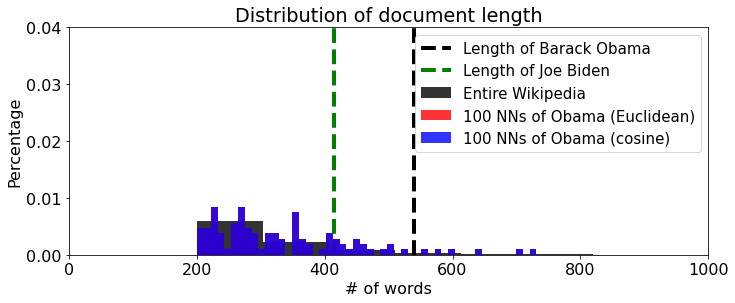

In [ ]:
plt.figure(figsize=(10.5,4.5))
plt.figure(figsize=(10.5,4.5))
plt.hist(data['length'], 50, color='k', edgecolor='None', histtype='stepfilled', density=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(rows['length'], 50, color='r', edgecolor='None', histtype='stepfilled', density=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.hist(rows2['length'], 50, color='b', edgecolor='None', histtype='stepfilled', density=True,
         label='100 NNs of Obama (cosine)', zorder=11, alpha=0.8)
plt.axvline(x=data[data['name'] == 'Barack Obama']['length'].iloc[0], color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=data[data['name'] == 'Joe Biden']['length'].iloc[0], color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])
plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

In [ ]:
sum(rows2['length'])/len(rows2['length'])

335.98

Indeed, the 100 nearest neighbors using cosine distance provide a sampling across the range of document lengths, rather than just short articles like Euclidean distance provided.

**Moral of the story**: In deciding the features and distance measures, check if they produce results that make sense for your particular application.